### Caso Base

Ponemos todos los nodos de localización en una sola lista

In [51]:
from pyomo.environ import *
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2

# =======================
# 1. Cargar datos
# =======================
clients_df = pd.read_csv('data_cases/caso_2/clients.csv')
depots_df = pd.read_csv('data_cases/caso_2/depots.csv')
vehicles_df = pd.read_csv('data_cases/caso_2/vehicles.csv')
stations_df = pd.read_csv('data_cases/caso_2/stations.csv')

# Coordenadas manuales de clientes
coords = {
    2: (-74.09893796560621, 4.59795431125545),
    3: (-74.07557103763986, 4.68782046838871),
    4: (-74.10708524062704, 4.70994460006024),
    5: (-74.0972965657427, 4.62050920686853),
    6: (-74.16464148202755, 4.68463876533332),
    7: (-74.12083799988112, 4.66213741965396),
    8: (-74.02213076607309, 4.69300943230983),
    9: (-74.17207549744595, 4.64941688426354),
    10: (-74.15615257246444, 4.60631065072393),
    11: (-74.09041145358674, 4.55737970582216),
    12: (-74.17802255204528, 4.59159407217295),
    13: (-74.1015410917749, 4.75641724063205),
    14: (-74.09609889182339, 4.64621700605052),
    15: (-74.1219200708342, 4.72591212531436),
}

# Agregar coordenadas de depósito
for _, row in depots_df.iterrows():
    coords[int(row['DepotID'])] = (float(row['Longitude']), float(row['Latitude']))

# Agregar estaciones (ID +100)
stations_df['NewID'] = stations_df['EstationID'] + 14
for _, row in stations_df.iterrows():
    coords[int(row['NewID'])] = (float(row['Longitude']), float(row['Latitude']))

# =======================
# 2. Preparar conjuntos y distancias
# =======================
clientes = clients_df['LocationID'].tolist()
depositos = depots_df['DepotID'].tolist()
estaciones = stations_df['NewID'].tolist()
vehiculos = vehicles_df['VehicleID'].tolist()

nodos = depositos + clientes + estaciones
n = len(nodos)

id_to_idx = {nodo: idx for idx, nodo in enumerate(nodos)}
idx_to_id = {idx: nodo for nodo, idx in id_to_idx.items()}

# Distancia haversine
def haversine(coord1, coord2):
    R = 6371
    lon1, lat1 = map(radians, coord1)
    lon2, lat2 = map(radians, coord2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

# Crear matriz de costos válida
cost_matrix = np.zeros((n, n))
valid_pairs = []

for i in range(n):
    for j in range(n):
        if i == j:
            continue
        ni, nj = nodos[i], nodos[j]

        if ni in estaciones and nj in estaciones:
            continue
        if ni in estaciones and nj in depositos:
            continue
        if ni in depositos and nj in estaciones:
            continue

        cost_matrix[i][j] = haversine(coords[ni], coords[nj])
        valid_pairs.append((i, j))

# =======================
# 3. Modelo Pyomo
# =======================
model = ConcreteModel()
model.N = RangeSet(0, n - 1)
model.K = RangeSet(1, len(vehiculos))
model.x_index = Set(initialize=valid_pairs)
model.x = Var(model.x_index, model.K, domain=Binary)
model.u = Var(model.N, model.K, domain=NonNegativeReals)

# Objetivo: minimizar distancia
def objetivo_rule(model):
    return sum(cost_matrix[i][j] * model.x[i, j, k]
               for (i, j) in model.x_index for k in model.K)
model.obj = Objective(rule=objetivo_rule, sense=minimize)

# Salida y entrada al depósito (nodo 0)
model.deposito = ConstraintList()
for k in model.K:
    model.deposito.add(sum(model.x[0, j, k] for (i, j) in model.x_index if i == 0) == 1)
    model.deposito.add(sum(model.x[j, 0, k] for (j, i) in model.x_index if i == 0) == 1)

# Conservación de flujo
model.flujo = ConstraintList()
for k in model.K:
    for i in model.N:
        if i != 0:
            model.flujo.add(
                sum(model.x[i, j, k] for (ii, j) in model.x_index if ii == i) ==
                sum(model.x[j, i, k] for (j, ii) in model.x_index if ii == i)
            )

# Subtour elimination
model.subtour = ConstraintList()
for k in model.K:
    for i in model.N:
        for j in model.N:
            if i != j and i != 0 and j != 0:
                if (i, j) in model.x_index:
                    model.subtour.add(model.u[i, k] - model.u[j, k] + n * model.x[i, j, k] <= n - 1)

# Visitar cada nodo una sola vez (excepto depósito)
model.una_visita = ConstraintList()
for i in model.N:
    if i != 0:
        model.una_visita.add(
            sum(model.x[i, j, k] for (ii, j) in model.x_index if ii == i for k in model.K) == 1
        )



In [ ]:
from pyomo.environ import *
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2

# ----------------------------
# CARGA DE DATOS
# ----------------------------
clients_df = pd.read_csv('data_cases/caso_2/clients.csv')
depots_df = pd.read_csv('data_cases/caso_2/depots.csv')
stations_df = pd.read_csv('data_cases/caso_2/stations.csv')
vehicles_df = pd.read_csv('data_cases/caso_2/vehicles.csv')

# Coordenadas manuales de clientes
coords = {
    2: (-74.09893796560621, 4.59795431125545),
    3: (-74.07557103763986, 4.68782046838871),
    4: (-74.10708524062704, 4.70994460006024),
    5: (-74.0972965657427, 4.62050920686853),
    6: (-74.16464148202755, 4.68463876533332),
    7: (-74.12083799988112, 4.66213741965396),
    8: (-74.02213076607309, 4.69300943230983),
    9: (-74.17207549744595, 4.64941688426354),
    10: (-74.15615257246444, 4.60631065072393),
    11: (-74.09041145358674, 4.55737970582216),
    12: (-74.17802255204528, 4.59159407217295),
    13: (-74.1015410917749, 4.75641724063205),
    14: (-74.09609889182339, 4.64621700605052),
    15: (-74.1219200708342, 4.72591212531436),
}

# Depósito
for _, row in depots_df.iterrows():
    coords[int(row['DepotID'])] = (row['Longitude'], row['Latitude'])

# Estaciones (ID + 100)
stations_df['NewID'] = stations_df['EstationID'] + 100
for _, row in stations_df.iterrows():
    coords[int(row['NewID'])] = (row['Longitude'], row['Latitude'])

clientes = clients_df['LocationID'].tolist()
deposito = depots_df['DepotID'].tolist()[0]
estaciones = stations_df['NewID'].tolist()
vehiculos = vehicles_df['VehicleID'].tolist()

nodos = [deposito] + clientes + estaciones
n = len(nodos)

# ----------------------------
# PARÁMETROS
# ----------------------------
demanda = dict(zip(clients_df['LocationID'], clients_df['Demand']))
capacidad = dict(zip(vehicles_df['VehicleID'], vehicles_df['Capacity']))
autonomia = dict(zip(vehicles_df['VehicleID'], vehicles_df['Range']))
precio_combustible = dict(zip(stations_df['NewID'], stations_df['FuelCost']))
consumo_km = 0.25  # litros por km

id_to_idx = {nodo: i for i, nodo in enumerate(nodos)}
idx_to_id = {i: nodo for nodo, i in id_to_idx.items()}

def haversine(coord1, coord2):
    R = 6371
    lon1, lat1 = map(radians, coord1)
    lon2, lat2 = map(radians, coord2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

cost_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:
            cost_matrix[i][j] = haversine(coords[nodos[i]], coords[nodos[j]])

# ----------------------------
# MODELO PYOMO
# ----------------------------
model = ConcreteModel()
model.N = RangeSet(0, n - 1)
model.K = RangeSet(1, len(vehiculos))

model.x = Var(model.N, model.N, model.K, within=Binary)
model.u = Var(model.N, model.K, within=NonNegativeReals)




model.fuel = Var(model.N, model.K, domain=NonNegativeReals)
model.refuel = Var(model.N, model.K, domain=NonNegativeReals)

for k in model.K:
    model.fuel[0, k].fix(autonomia[k])

# Objetivo: minimizar distancia y costo de gasolina 


model.obj = Objective(
    expr=sum(
        cost_matrix[i][j] * model.x[i, j, k]
        for i in model.N for j in model.N for k in model.K if i != j
    ) +
    sum(
        precio_combustible.get(idx_to_id[i], 0) * model.refuel[i, k]
        for i in model.N for k in model.K
    ),
    sense=minimize
)


# Restricciones
model.deposito = ConstraintList()
for k in model.K:
    model.deposito.add(sum(model.x[0, j, k] for j in model.N if j != 0) == 1)
    model.deposito.add(sum(model.x[j, 0, k] for j in model.N if j != 0) == 1)

model.flujo = ConstraintList()
for k in model.K:
    for i in model.N:
        if i != 0:
            model.flujo.add(
                sum(model.x[i, j, k] for j in model.N if i != j) ==
                sum(model.x[j, i, k] for j in model.N if i != j)
            )

model.subtour = ConstraintList()
for k in model.K:
    for i in model.N:
        for j in model.N:
            if i != j and i != 0 and j != 0:
                model.subtour.add(
                    model.u[i, k] - model.u[j, k] + n * model.x[i, j, k] <= n - 1
                )

model.visita = ConstraintList()
for i in model.N:
    if i != 0:
        model.visita.add(
            sum(model.x[i, j, k] for j in model.N for k in model.K if i != j) == 1
       )


model.capacidad_total = ConstraintList()
for k in model.K:
    model.capacidad_total.add(
        sum(
            demanda.get(idx_to_id[i], 0) * sum(model.x[i, j, k] for j in model.N if i != j)
            for i in model.N
        ) <= capacidad[k]
    )

# Combustible
model.restriccion_combustible = ConstraintList()
for k in model.K:
    for i in model.N:
        for j in model.N:
            if i != j:
                distancia = cost_matrix[i][j]
                model.restriccion_combustible.add(
                    model.fuel[j, k] <= model.fuel[i, k] - consumo_km * distancia * model.x[i, j, k] + model.refuel[j, k]
                )

# Combustible nunca puede superar el tanque
model.limite_tanque = ConstraintList()
for k in model.K:
    for i in model.N:
        model.limite_tanque.add(model.fuel[i, k] <= autonomia[k])



# SOLVER

solver = SolverFactory("glpk")
solver.options["tmlim"] = 60
solver.solve(model)


# IMPRIMIR RUTAS

routes = {k: [] for k in model.K}
for k in model.K:
    actual = 0
    visitados = set()
    while True:
        next_node = None
        for j in model.N:
            if j != actual and model.x[actual, j, k].value is not None and model.x[actual, j, k].value > 0.5:
                next_node = j
                break
        if next_node is None or next_node in visitados:
            break
        routes[k].append(next_node)
        visitados.add(next_node)
        actual = next_node

for k, ruta in routes.items():
    traducida = [idx_to_id[i] for i in [0] + ruta + [0]]
    print(f"Camión {k}: {' → '.join(map(str, traducida))}")


Camión 1: 1 → 108 → 15 → 4 → 3 → 14 → 6 → 106 → 1 → 1
Camión 2: 1 → 10 → 107 → 2 → 11 → 102 → 1 → 1
Camión 3: 1 → 103 → 8 → 112 → 7 → 111 → 5 → 105 → 1 → 1
Camión 4: 1 → 9 → 110 → 13 → 104 → 12 → 109 → 1 → 1
Camión 5: 1 → 101 → 1 → 1


In [86]:
print("\nDistancia recorrida por cada camión:")
distancias = {}
for k in model.K:
    distancia = 0
    for i in model.N:
        for j in model.N:
            if i != j and model.x[i, j, k].value is not None and model.x[i, j, k].value > 0.5:
                distancia += cost_matrix[i][j]
    distancias[k] = distancia
    print(f"Camión {k}: {round(distancia, 2)} km")

print(f"\nDistancia total recorrida: {round(sum(distancias.values()), 2)} km")


Distancia recorrida por cada camión:
Camión 1: 1658.79 km
Camión 2: 2318.61 km
Camión 3: 2404.9 km
Camión 4: 1508.71 km
Camión 5: 0.0 km

Distancia total recorrida: 7891.02 km


In [96]:
import matplotlib.pyplot as plt
import random

def graficar_rutas_pyomo(routes, idx_to_id, coords):
    plt.figure(figsize=(10, 10))
    plt.title("Rutas por Vehículo")

    # Dibujar nodos
    for nodo, (lon, lat) in coords.items():
        es_deposito = nodo == 1
        es_estacion = nodo >= 100
        color = 'ko' if es_deposito else ('go' if es_estacion else 'bo')
        plt.plot(lon, lat, color)
        plt.text(lon + 0.003, lat + 0.003, str(nodo), fontsize=9)

    # Dibujar rutas
    for k, ruta in routes.items():
        ruta_completa = [0] + ruta + [0]  # índice interno
        color = "#" + ''.join(random.choices('0123456789ABCDEF', k=6))
        for i in range(len(ruta_completa) - 1):
            origen = idx_to_id[ruta_completa[i]]
            destino = idx_to_id[ruta_completa[i+1]]
            x1, y1 = coords[origen]
            x2, y2 = coords[destino]
            plt.plot([x1, x2], [y1, y2], color=color, linewidth=2)

    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.grid(True)
    plt.show()



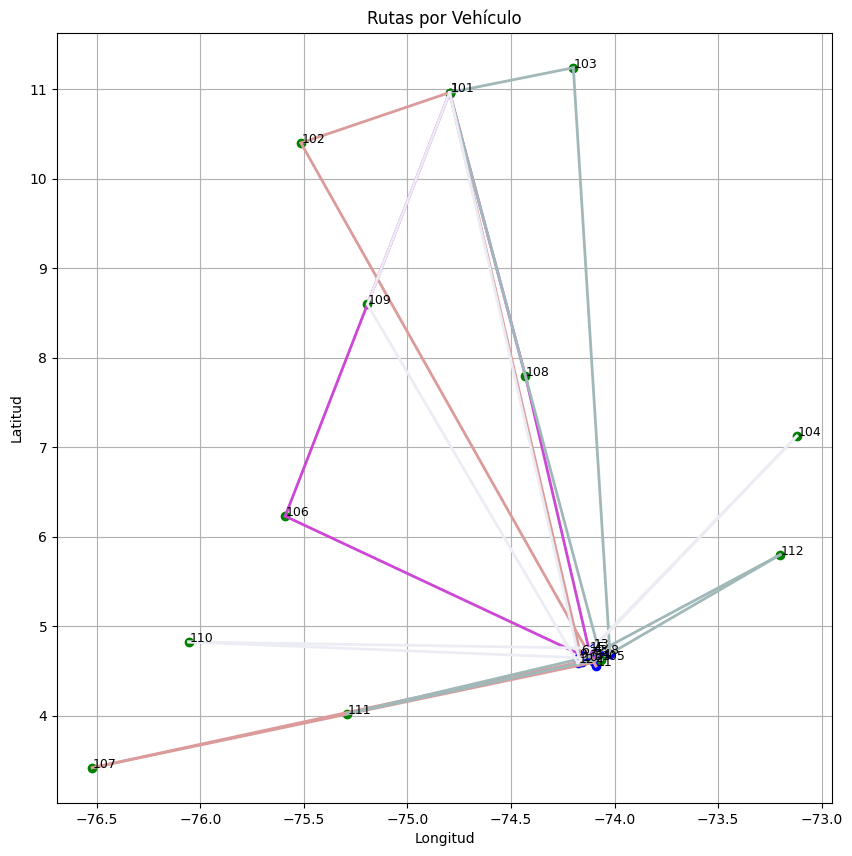

In [97]:
graficar_rutas_pyomo(routes, idx_to_id, coords)


In [99]:
%pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [folium]
Note: you may need to restart the kernel to use updated packages.


In [106]:
import folium
from folium import Map, Marker, PolyLine
import random

def graficar_rutas_en_folium(routes, idx_to_id, coords):
    # Crear mapa centrado en Bogotá
    mapa = folium.Map(location=[4.65, -74.1], zoom_start=11)

    # Colores para cada camión
    colores = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'black']

    # Marcar todos los nodos
    for nodo_id, (lon, lat) in coords.items():
        tipo = 'Depósito' if nodo_id == 1 else ('Estación' if nodo_id >= 100 else 'Cliente')
        color = 'black' if tipo == 'Depósito' else ('green' if tipo == 'Estación' else 'blue')
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            color=color,
            fill=True,
            fill_opacity=0.9,
            popup=f"{tipo} {nodo_id}"
        ).add_to(mapa)

    # Dibujar rutas por camión
   # Dibujar rutas por camión
    for k, ruta in routes.items():
        ruta_completa = [0] + ruta + [0]  # índice → empieza y termina en depósito
        puntos = []
        for i in range(len(ruta_completa) - 1):
            origen = idx_to_id[ruta_completa[i]]
            destino = idx_to_id[ruta_completa[i + 1]]
            lon1, lat1 = coords[origen]  # ✔️ Aquí corregimos el orden
            lon2, lat2 = coords[destino]
            puntos.append([[lat1, lon1], [lat2, lon2]])  # ✔️ folium requiere [lat, lon]
        color = colores[(k - 1) % len(colores)]
        for segmento in puntos:
            folium.PolyLine(locations=segmento, color=color, weight=4, opacity=0.8,
                            popup=f"Camión {k}").add_to(mapa)


    return mapa


In [107]:
mapa = graficar_rutas_en_folium(routes, idx_to_id, coords)
mapa
